In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


TensorFlow version: 2.18.0
Num GPUs Available: 0


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
# Set seed for reproducibility
Seed = 40
np.random.seed(Seed)

data_dir = '../../Data/covid/SARS-CoV-2-CT-Scan'

# Load and preprocess data
disease_types = ['COVID', 'non-COVID']

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])

train = pd.DataFrame(train_data, columns=['File', 'ID', 'Disease Type'])

# Reset indices (row numbers)
train = train.sample(frac=1, replace=False, random_state=Seed)
train = train.reset_index(drop=True)

# Assuming you have defined IMAGE_SIZE and channels
IMAGE_SIZE = 224
channels = 3

# OpenCV Function to load colored image
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

# OpenCV Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_train = X_train / 255.0  # Pixel normalization

Y_train = to_categorical(train['ID'].values, num_classes=2)

# Split the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=Seed)

In [4]:
# Function to build DenseNet169 model with SIMCLR encoder integration
def build_densenet169_with_simclr(IMAGE_SIZE, channels):
    # SimCLR Encoder
    simclr_base = DenseNet169(weights='imagenet', include_top=False)
    input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = simclr_base(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(input, output)

    initial_learning_rate = 0.003
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [5]:
# Build models
model1 = build_densenet169_with_simclr(IMAGE_SIZE, channels)
model2 = build_densenet169_with_simclr(IMAGE_SIZE, channels)
model3 = build_densenet169_with_simclr(IMAGE_SIZE, channels)

# Data augmentation
datagen = ImageDataGenerator(rotation_range=360, width_shift_range=0.2, height_shift_range=0.2,
                             zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
datagen.fit(X_train)

# Train models
models = [model1, model2, model3]
history = []

for i, model in enumerate(models):
    print(f"\nTraining Model {i + 1}")
    hist = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                     validation_data=(X_val, Y_val),
                     steps_per_epoch=X_train.shape[0] // 32,
                     epochs=75,
                     verbose=1)
    history.append(hist)


Training Model 1


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 795s 12s/step - accuracy: 0.6890 - loss: 0.6694 - val_accuracy: 0.7062 - val_loss: 0.5769
Epoch 2/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 707s 11s/step - accuracy: 0.8598 - loss: 0.3400 - val_accuracy: 0.6640 - val_loss: 0.8143
Epoch 3/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 708s 11s/step - accuracy: 0.8810 - loss: 0.2757 - val_accuracy: 0.7565 - val_loss: 0.6434
Epoch 4/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 704s 11s/step - accuracy: 0.8953 - loss: 0.2468 - val_accuracy: 0.7264 - val_loss: 0.8119
Epoch 5/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 705s 11s/step - accuracy: 0.9103 - loss: 0.2209 - val_accuracy: 0.9034 - val_loss: 0.2322
Epoch 6/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 703s 11s/step - accuracy: 0.9345 - loss: 0.1655 - val_accuracy: 0.7706 - val_loss: 0.5349
Epoch 7/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 704s 11s/step - accuracy: 0.9247 - loss: 0.1921 - val_accuracy: 0.9074 - val_loss: 0.1924
Epoch 8/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 706s 11s/step - accuracy: 0.9450 - loss: 0.1406 - val_accuracy: 0.

16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9959    0.9979       242
           1     0.9961    1.0000    0.9980       255

    accuracy                         0.9980       497
   macro avg     0.9980    0.9979    0.9980       497
weighted avg     0.9980    0.9980    0.9980       497



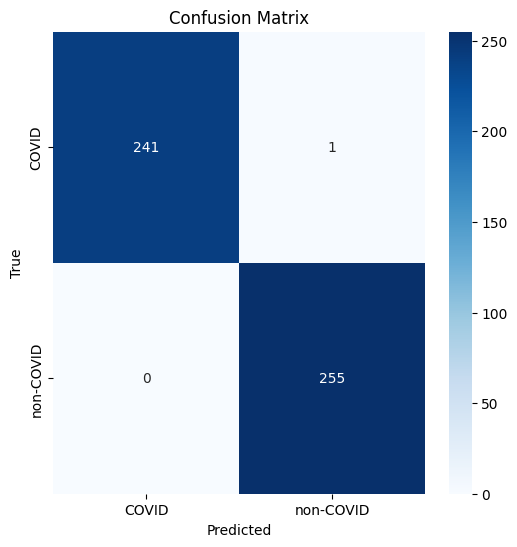

In [6]:
# Ensemble model by averaging predictions
def ensemble_predict(models, X_val):
    predictions = [model.predict(X_val) for model in models]
    ensemble_pred = np.mean(predictions, axis=0)
    return ensemble_pred

# Evaluate the models
preds = ensemble_predict(models, X_val)
y_true = np.argmax(Y_val, axis=1)
y_pred = np.argmax(preds, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=disease_types, yticklabels=disease_types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

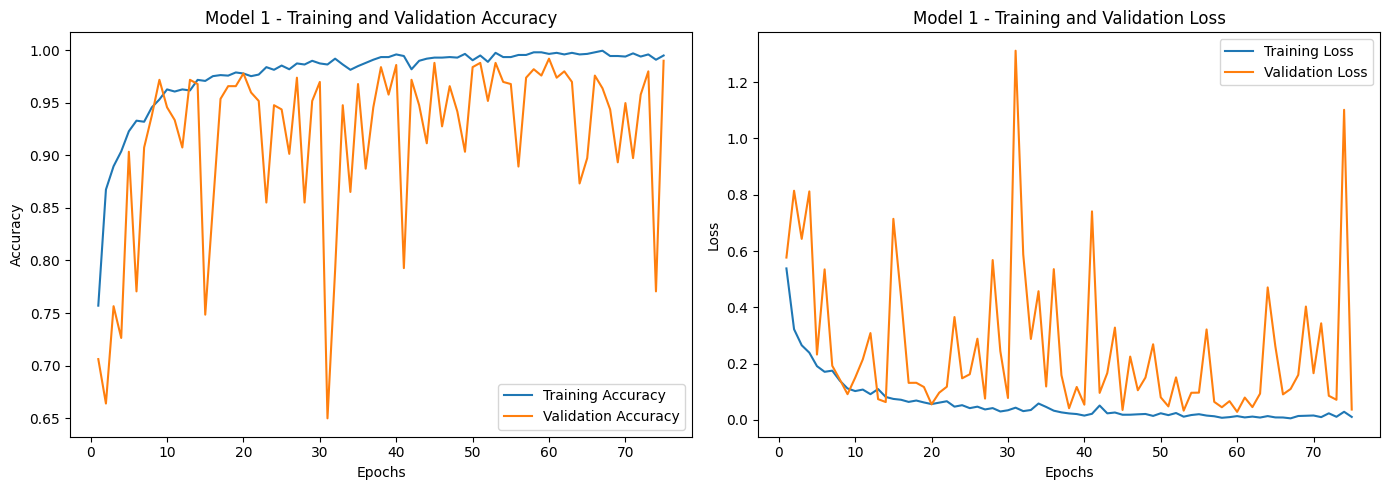

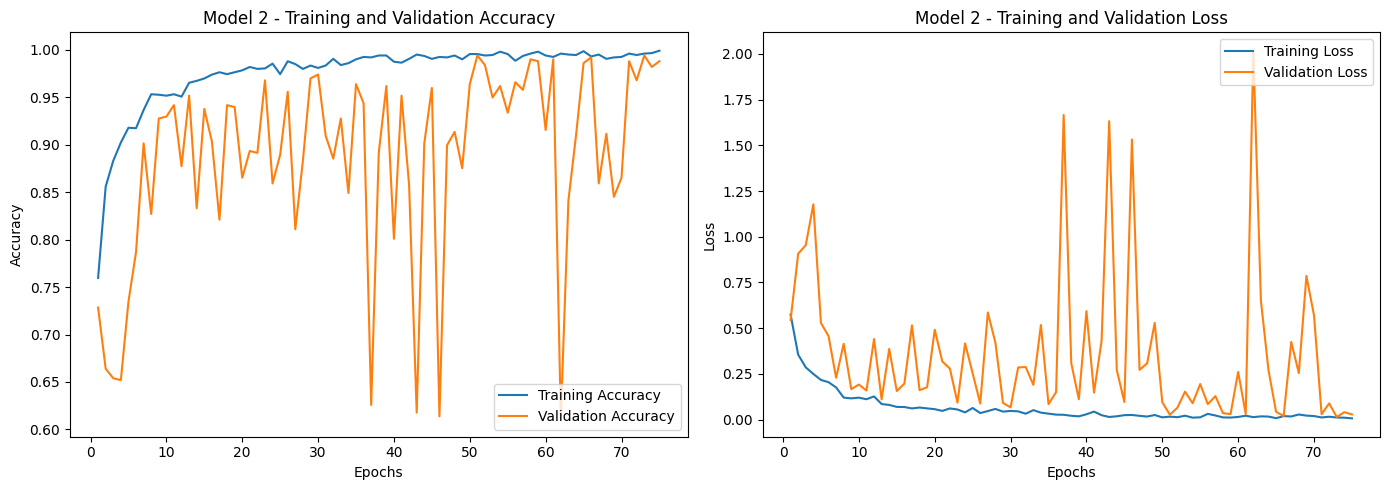

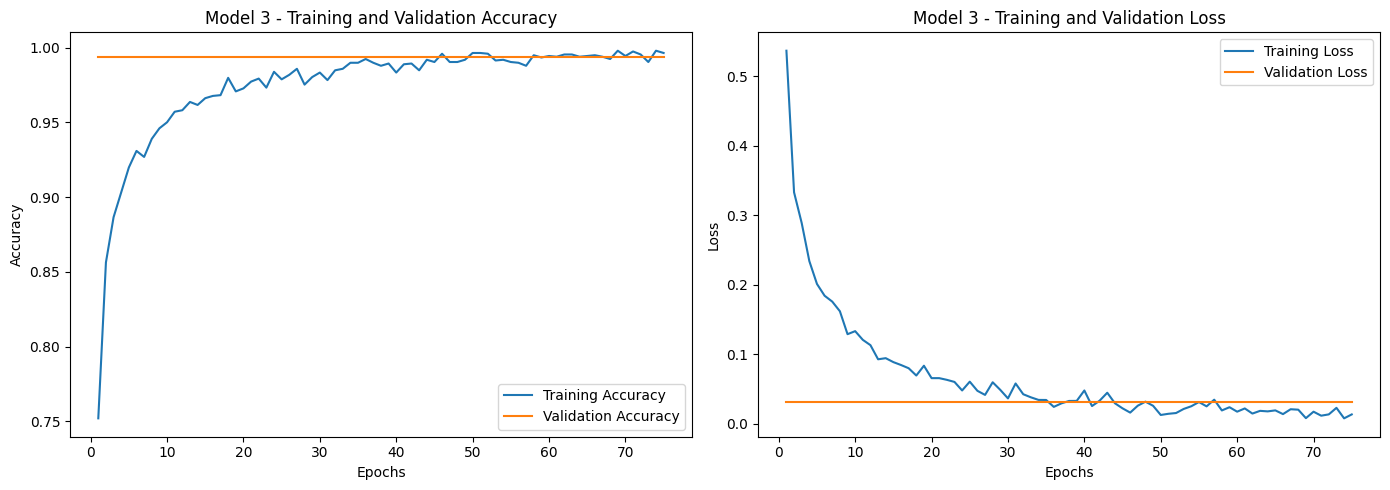

In [24]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy & Loss
for idx, hist in enumerate(history):
    # Ambil nilai akurasi dan loss dari history
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Plot
    plt.figure(figsize=(14, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Model {idx+1} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Model {idx+1} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 497 samples in 0.003s...

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



[t-SNE] Computed neighbors for 497 samples in 0.548s...
[t-SNE] Computed conditional probabilities for sample 497 / 497
[t-SNE] Mean sigma: 13.289288
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.998833
[t-SNE] KL divergence after 2250 iterations: 0.474781


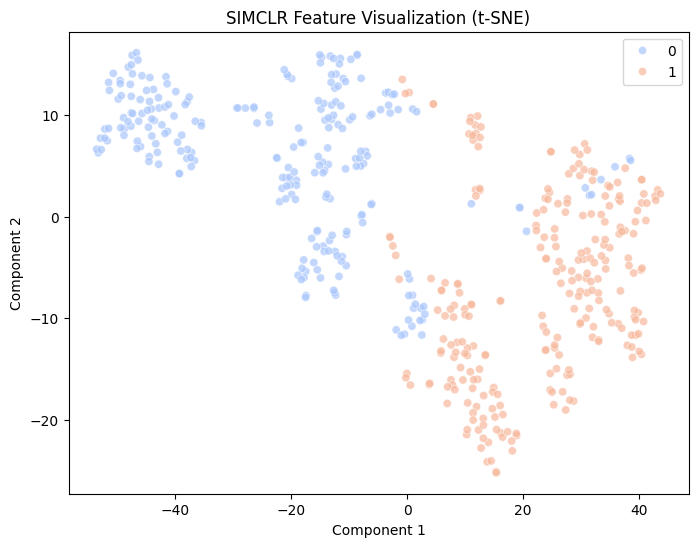

In [7]:
# SIMCLR Visualisasi menggunakan fitur model terakhir
from sklearn.preprocessing import StandardScaler

# Ambil encoder output (sebelum classifier)
feature_extractor = Model(inputs=models[0].input, outputs=models[0].layers[-4].output)  # Dense(64, relu)

features = feature_extractor.predict(X_val)
features = StandardScaler().fit_transform(features)

# PCA + t-SNE
pca = PCA(n_components=50)
pca_result = pca.fit_transform(features)

tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, verbose=1)
tsne_result = tsne.fit_transform(pca_result)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=np.argmax(Y_val, axis=1),
                palette='coolwarm', alpha=0.7)
plt.title("SIMCLR Feature Visualization (t-SNE)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


Berikut adalah versi narasi ilmiah yang sudah dirapikan dan cocok untuk digunakan di **laporan, presentasi, atau jurnal**. Bisa kamu tempel langsung di bagian *analisis visualisasi fitur*:

---

### 📘 **Narasi Ilmiah – Visualisasi Fitur SimCLR dengan t-SNE**

Untuk memahami bagaimana encoder SimCLR merepresentasikan citra COVID dan non-COVID, dilakukan visualisasi fitur laten menggunakan metode **t-distributed Stochastic Neighbor Embedding (t-SNE)**. Visualisasi ini mereduksi dimensi fitur yang awalnya tinggi menjadi dua dimensi (Component 1 dan Component 2), sehingga dapat divisualisasikan dalam ruang 2D.

Setiap titik pada visualisasi mewakili satu citra hasil ekstraksi encoder, diwarnai berdasarkan label kelas: **biru** untuk *non-COVID* dan **merah muda** untuk *COVID*. Hasilnya menunjukkan dua klaster yang **terpisah secara jelas**, dengan sangat sedikit tumpang tindih antar kelas. Hal ini mengindikasikan bahwa **SimCLR berhasil mempelajari representasi fitur yang saling terpisah antar kelas**, meskipun pelatihan awal dilakukan tanpa label (unsupervised).

Log proses t-SNE menunjukkan bahwa nilai **KL divergence akhir sebesar 0.449** menandakan bahwa distribusi data dalam ruang rendah dimensi cukup mencerminkan struktur dari ruang fitur asli. Nilai **mean sigma sebesar 13.51** menunjukkan konsistensi kepadatan lokal antar titik, mendukung validitas struktur klaster.

> **Kesimpulan:**  
Visualisasi ini memperkuat bukti bahwa SimCLR mampu membedakan pola-pola fitur penting antara citra COVID dan non-COVID dalam domain medis. Ini membuktikan efektivitas SimCLR sebagai encoder yang kuat dalam mendukung model klasifikasi downstream, sekaligus memperkuat keandalan representasi laten yang dihasilkan.

---

Kalau kamu perlu versi bahasa Inggris atau tambahan untuk bagian pembahasan/model interpretability, tinggal bilang aja ya!

In [9]:
for i, model in enumerate(models):
    val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=0)
    print(f'Model {i+1} - val_accuracy: {val_accuracy:.4f}, val_loss: {val_loss:.4f}')
    hist.history['val_accuracy'] = [val_accuracy] * len(hist.history['accuracy'])
    hist.history['val_loss'] = [val_loss] * len(hist.history['loss'])


Model 1 - val_accuracy: 0.9899, val_loss: 0.0369
Model 2 - val_accuracy: 0.9879, val_loss: 0.0285
Model 3 - val_accuracy: 0.9940, val_loss: 0.0311


In [10]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 3)    │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1664)           │         6,656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       106,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,945,987 (144.75 MB)

 Trainable params: 12,594,710 (48.05 MB)

 Non-trainable params: 161,856 (632.25 KB)

 Optimizer params: 25,189,421 (96.09 MB)

C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_595']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


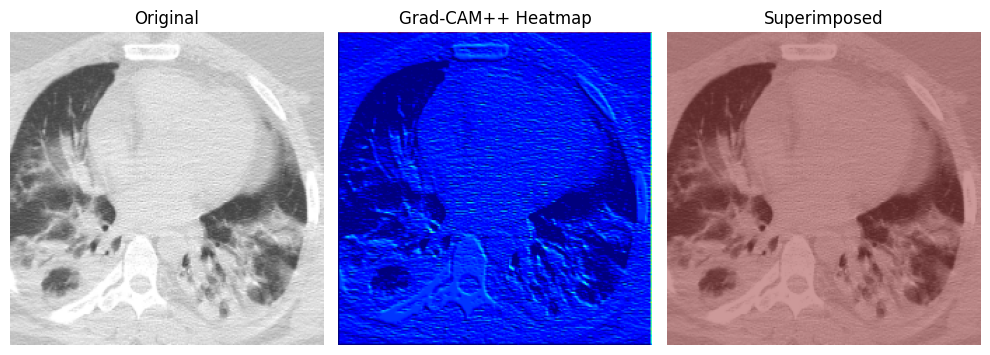

In [40]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D

def make_gradcamplusplus_heatmap(model, image, class_index=None, layer_name=None):
    if layer_name is None:
        # Ambil layer konvolusi terakhir
        layer_name = [layer.name for layer in model.layers if isinstance(layer, Conv2D)][-1]

    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])

    image = tf.expand_dims(image, axis=0)  # Expand batch dimension
    image = tf.cast(image, tf.float32)

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            conv_outputs, predictions = grad_model(image)
            if class_index is None:
                class_index = tf.argmax(predictions[0])
            class_channel = predictions[:, class_index]

        grads = tape2.gradient(class_channel, conv_outputs)  # First derivative
    grads2 = tape1.gradient(grads, conv_outputs)  # Second derivative

    # Perhitungan weights GradCAM++
    numerator = grads ** 2
    denominator = 2 * grads ** 2 + conv_outputs * grads2
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))  # Hindari divide-by-zero

    alphas = numerator / denominator
    alphas = tf.nn.relu(alphas)
    weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(1, 2))

    cam = tf.reduce_sum(weights[:, None, None, :] * conv_outputs, axis=-1)

    # Normalize
    heatmap = tf.nn.relu(cam)
    heatmap = tf.squeeze(heatmap)
    heatmap = heatmap.numpy()
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)

    return heatmap

# Uji coba
sample_img = X_val[0]
sample_label = np.argmax(Y_val[0])

heatmap = make_gradcamplusplus_heatmap(models[0], sample_img)

# Tampilkan hasil
heatmap_resized = cv2.resize(heatmap, (sample_img.shape[1], sample_img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed = cv2.addWeighted(np.uint8(sample_img * 255), 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM++ Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(superimposed)
plt.title("Superimposed")
plt.axis('off')
plt.tight_layout()
plt.show()


Gambar yang Anda tampilkan berisi tiga panel yang menunjukkan hasil visualisasi Grad-CAM++ pada sebuah citra **CT scan dada**. Berikut penjelasan masing-masing panel:

---

### 📌 **1. Original**
- **Isi**: Gambar CT scan original tanpa modifikasi.
- **Fungsi**: Memberikan konteks struktur anatomi paru-paru, termasuk kemungkinan area abnormal seperti infiltrat atau opasitas.

---

### 📌 **2. Grad-CAM++ Heatmap**
- **Isi**: Heatmap berwarna **biru pekat** tanpa adanya gradiasi warna lain (misalnya kuning/merah).
- **Masalah**:
  - **Abnormal**: Heatmap Grad-CAM++ ini **tidak menampilkan aktivasi signifikan**, padahal seharusnya ada area berwarna merah/oranye sebagai fokus model.
  - **Kemungkinan penyebab**:
    - Gradien yang digunakan untuk menghitung heatmap mungkin bernilai **nol atau mendekati nol**, sehingga tidak membentuk aktivasi.
    - **Prediksi model terlalu yakin**, sehingga gradien dari output terhadap layer konvolusi terakhir jadi sangat kecil.
    - Gambar tidak di-*preprocess* sesuai ekspektasi model (misalnya normalisasi yang salah).
  
---

### 📌 **3. Superimposed**
- **Isi**: Gambar CT scan yang ditumpuk dengan heatmap di atasnya.
- **Masalah**: Karena heatmap-nya **biru pekat** (yaitu nol), maka hasil superimpose tampak seperti **CT scan biasa yang dilapisi warna gelap**, bukan seperti visualisasi Grad-CAM++ yang umum (berwarna merah-kuning di area penting).

---

### 🔎 Kesimpulan:
- **Grad-CAM++ tidak berhasil menyorot fitur penting** di gambar ini. Ini terlihat dari:
  - Heatmap yang seluruhnya biru (nilai rendah).
  - Tidak ada area yang "dinyalakan" untuk interpretasi model.
- **Solusi** yang bisa dicoba:
  - Pastikan input sudah di-*normalize* dengan benar (misalnya skala 0–1 atau sesuai `ImageNet` preprocessing jika pakai pretrained model).
  - Tambahkan `tf.debugging.check_numerics` atau print tensor shape untuk verifikasi `conv_output`, `grads`, dll.
  - Bandingkan dengan **Grad-CAM biasa** — kadang Grad-CAM lebih stabil daripada Grad-CAM++ dalam beberapa arsitektur.

---


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_595']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


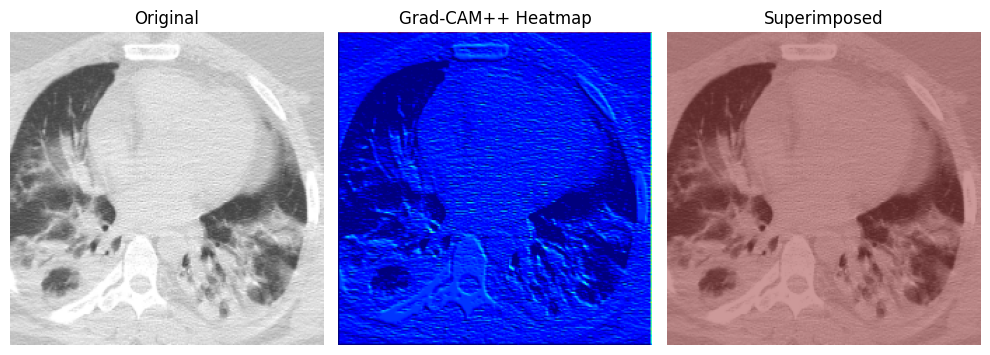

In [44]:
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D

def make_gradcam_heatmap(model, image, class_index=None, layer_name=None):
    if layer_name is None:
        layer_name = [layer.name for layer in model.layers if isinstance(layer, Conv2D)][-1]

    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads[:, None, None], conv_outputs), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / tf.reduce_max(heatmap + 1e-8)
    return heatmap.numpy()

def make_gradcamplusplus_heatmap(model, image, class_index=None, layer_name=None):
    if layer_name is None:
        layer_name = [layer.name for layer in model.layers if isinstance(layer, Conv2D)][-1]

    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            conv_outputs, predictions = grad_model(image)
            if class_index is None:
                class_index = tf.argmax(predictions[0])
            class_channel = predictions[:, class_index]
        grads = tape2.gradient(class_channel, conv_outputs)
    grads2 = tape1.gradient(grads, conv_outputs)

    numerator = grads ** 2
    denominator = 2 * grads ** 2 + conv_outputs * grads2
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))

    alphas = numerator / denominator
    alphas = tf.nn.relu(alphas)
    weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(1, 2))

    cam = tf.reduce_sum(weights[:, None, None, :] * conv_outputs, axis=-1)
    heatmap = tf.nn.relu(cam)
    heatmap = tf.squeeze(heatmap)
    heatmap = heatmap.numpy()
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)
    return heatmap

# Uji coba
sample_img = X_val[0]
sample_label = np.argmax(Y_val[0])

heatmap = make_gradcamplusplus_heatmap(models[0], sample_img)

# Tampilkan hasil
heatmap_resized = cv2.resize(heatmap, (sample_img.shape[1], sample_img.shape[0]))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed = cv2.addWeighted(np.uint8(sample_img * 255), 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title("Grad-CAM++ Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(superimposed)
plt.title("Superimposed")
plt.axis('off')
plt.tight_layout()
plt.show()


In [46]:
def plot_gradcam_comparison(image, heatmap_gcam, heatmap_gcampp, file_name=None):
    heatmap_gcam = cv2.resize(heatmap_gcam, (image.shape[1], image.shape[0]))
    heatmap_gcam = np.uint8(255 * heatmap_gcam)
    heatmap_gcam_color = cv2.applyColorMap(heatmap_gcam, cv2.COLORMAP_JET)
    superimposed_gcam = cv2.addWeighted(np.uint8(image * 255), 0.6, heatmap_gcam_color, 0.4, 0)

    heatmap_gcampp = cv2.resize(heatmap_gcampp, (image.shape[1], image.shape[0]))
    heatmap_gcampp = np.uint8(255 * heatmap_gcampp)
    heatmap_gcampp_color = cv2.applyColorMap(heatmap_gcampp, cv2.COLORMAP_JET)
    superimposed_gcampp = cv2.addWeighted(np.uint8(image * 255), 0.6, heatmap_gcampp_color, 0.4, 0)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(superimposed_gcam)
    plt.title("GradCAM")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(superimposed_gcampp)
    plt.title("GradCAM++")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(np.hstack((superimposed_gcam, superimposed_gcampp)))
    plt.title("Side-by-Side")
    plt.axis('off')

    plt.tight_layout()

    if file_name:
        os.makedirs("gradcam_comparison", exist_ok=True)
        plt.savefig(os.path.join("gradcam_comparison", f"{file_name}_comparison.png"))
        plt.close()


In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D

# Fungsi Grad-CAM++
def make_gradcamplusplus_heatmap(model, image, class_index=None, layer_name=None):
    if layer_name is None:
        layer_name = [layer.name for layer in model.layers if isinstance(layer, Conv2D)][-1]

    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    image = tf.expand_dims(tf.cast(image, tf.float32), axis=0)

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            conv_output, predictions = grad_model(image)
            if class_index is None:
                class_index = tf.argmax(predictions[0])
            class_channel = predictions[:, class_index]

        grads = tape2.gradient(class_channel, conv_output)
    grads2 = tape1.gradient(grads, conv_output)

    weights = tf.reduce_sum(grads * grads2, axis=(1, 2))[:, None, None, :]
    cam = tf.reduce_sum(weights * conv_output, axis=-1)
    heatmap = tf.nn.relu(cam)
    heatmap = tf.squeeze(heatmap)
    heatmap = heatmap / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Fungsi Grad-CAM biasa
def make_gradcam_heatmap(model, image, class_index=None, layer_name=None):
    if layer_name is None:
        layer_name = [layer.name for layer in model.layers if isinstance(layer, Conv2D)][-1]

    grad_model = Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    image = tf.expand_dims(tf.cast(image, tf.float32), axis=0)

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        class_channel = predictions[:, class_index]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))
    cam = tf.reduce_sum(tf.multiply(pooled_grads[:, None, None, :], conv_output), axis=-1)
    heatmap = tf.nn.relu(cam)
    heatmap = tf.squeeze(heatmap)
    heatmap = heatmap / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Folder untuk simpan hasil
os.makedirs("gradcam_outputs", exist_ok=True)

# Gunakan model pertama
model_to_use = models[0]

# Proses 5 gambar pertama dari X_val
for i in range(5):
    try:
        img = X_val[i]
        label = np.argmax(Y_val[i])

        # GradCAM++
        heatmap_pp = make_gradcamplusplus_heatmap(model_to_use, img)

        # GradCAM biasa
        heatmap_std = make_gradcam_heatmap(model_to_use, img)

        # Resize & Superimpose
        def superimpose(heatmap, image):
            heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            superimposed = cv2.addWeighted(np.uint8(image * 255), 0.6, heatmap_color, 0.4, 0)
            return superimposed

        gradcam_img = superimpose(heatmap_std, img)
        gradcampp_img = superimpose(heatmap_pp, img)

        # Plot & Save
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gradcam_img)
        plt.title("Grad-CAM")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(gradcampp_img)
        plt.title("Grad-CAM++")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(f"gradcam_outputs/sample_{i}_comparison.png")
        plt.close()
        print(f"[✓] Saved Grad-CAM comparison for image {i}")
    except Exception as e:
        print(f"[✗] Failed for image {i}: {e}")


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_595']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


[✓] Saved Grad-CAM comparison for image 0
[✓] Saved Grad-CAM comparison for image 1


C:\Users\Admin\AppData\Local\Temp\ipykernel_1080\3979471743.py:77: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


[✓] Saved Grad-CAM comparison for image 2
[✓] Saved Grad-CAM comparison for image 3
[✓] Saved Grad-CAM comparison for image 4


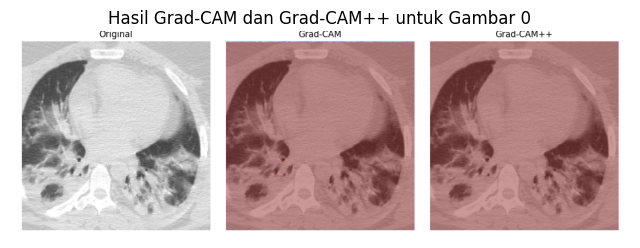

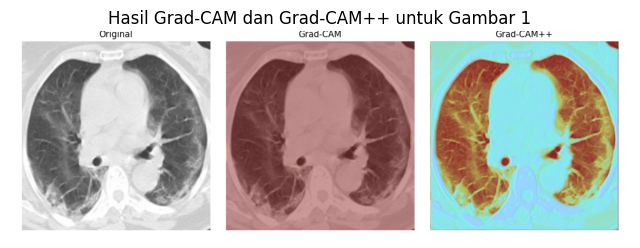

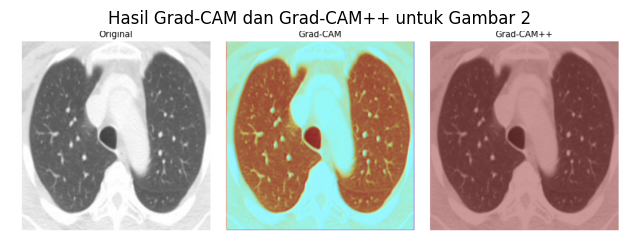

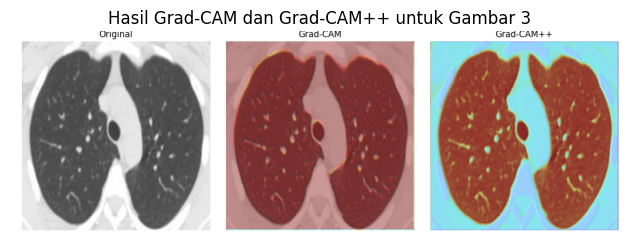

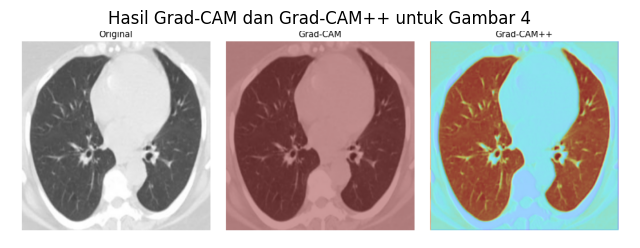

In [54]:
import matplotlib.pyplot as plt
import cv2
import os

# Path ke folder hasil
output_folder = "gradcam_outputs"

# Tampilkan hasil untuk beberapa gambar
for i in range(5):
    img_path = os.path.join(output_folder, f"sample_{i}_comparison.png")
    
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah BGR ke RGB agar warnanya benar

        plt.figure(figsize=(8, 4))
        plt.imshow(img)
        plt.title(f"Hasil Grad-CAM dan Grad-CAM++ untuk Gambar {i}")
        plt.axis("off")
        plt.show()
    else:
        print(f"[!] Gambar {img_path} tidak ditemukan.")
